[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/davemlz/eemont/blob/master/docs/tutorials/013-Time-Series-By-Region-Pandas.ipynb)
[![Open in SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/davemlz/eemont/blob/master/docs/tutorials/013-Time-Series-By-Region-Pandas.ipynb)
[![Open in Planetary Computer](https://img.shields.io/badge/Open-Planetary%20Computer-black?style=flat&logo=microsoft)](https://pccompute.westeurope.cloudapp.azure.com/compute/hub/user-redirect/git-pull?repo=https://github.com/davemlz/eemont&urlpath=lab/tree/eemont/docs/tutorials/013-Time-Series-By-Region-Pandas.ipynb&branch=master)

# Time Series By Region (with Conversion to Pandas and Visualization with Seaborn)

_Tutorial created by **David Montero Loaiza**_: [GitHub](https://github.com/davemlz) | [Twitter](https://twitter.com/dmlmont)

- GitHub Repo: [https://github.com/davemlz/eemont](https://github.com/davemlz/eemont)
- PyPI link: [https://pypi.org/project/eemont/](https://pypi.org/project/eemont/)
- Conda-forge: [https://anaconda.org/conda-forge/eemont](https://anaconda.org/conda-forge/eemont)
- Documentation: [https://eemont.readthedocs.io/](https://eemont.readthedocs.io/)
- More tutorials: [https://github.com/davemlz/eemont/tree/master/docs/tutorials](https://github.com/davemlz/eemont/tree/master/docs/tutorials)

## Let's start!

If required, please uncomment:

In [1]:
#!pip install eemont
#!pip install geemap

Import the required packges.

In [2]:
import ee, eemont, geemap
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

Authenticate and Initialize Earth Engine and geemap.

In [3]:
Map = geemap.Map()

Let's use a buffered point for the time series!

In [4]:
point = ee.Geometry.Point([11.178576,51.122064]).buffer(100)

Let's pre-process and process our image collection:

In [5]:
L8 = (ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
      .filterBounds(point)
      .maskClouds()
      .scaleAndOffset()
      .spectralIndices(['GNDVI','EVI']))

## Time Series By Region

Let's get the L8 time series for our buffer. Checklist:

- Image Collection: The Landsat 8 collection.
- Bands to use for the time series: GNDVI and EVI.
- Geometry: Our buffered point.
- Statistics to compute: Minimum, Mean, and Maximum.
- Scale: 30 m.

In [6]:
ts = L8.getTimeSeriesByRegion(geometry = point,
                              bands = ['EVI','GNDVI'],
                              reducer = [ee.Reducer.min(),ee.Reducer.mean(),ee.Reducer.max()],
                              scale = 30)

## Conversion to Pandas

The time series is retrieved as a feature collection. To convert it to a pandas dataframe we'll use `geemap` (This may take a little bit):

In [7]:
tsPandas = geemap.ee_to_pandas(ts)

Let's check our pandas data frame:

In [8]:
tsPandas

,EVI,GNDVI,reducer,date
0,-9999.000000,-9999.000000,min,2013-04-20T10:04:44
1,-9999.000000,-9999.000000,min,2013-06-07T10:04:59
2,0.556182,0.653012,min,2013-07-09T10:04:56
3,0.624375,0.610642,min,2013-07-25T10:04:55
4,0.652409,0.768563,min,2013-08-10T10:04:57
...,...,...,...,...
739,-9999.000000,-9999.000000,max,2021-07-22T10:09:06
740,-9999.000000,-9999.000000,max,2021-08-07T10:09:14
741,-9999.000000,-9999.000000,max,2021-08-23T10:09:18
742,0.648737,0.834015,max,2021-09-08T10:09:23


What can we see here?

- The values for each band (GNDVI and EVI) are in separated columns.
- There are some -9999 values in the GNDVI and EVI columns. These values represent the NA values (e.g. Clouds or shadows). The -9999 can be changed by modifying the `naValue` parameter in the `getTimeSeriesByRegion` method (e.g. `naValue = -10000`).
- Multiple reducers can be used. In the output dataframe they are specified by a single column named `reducer`: min, mean, max.
- The date is a string that needs to be converted to a date data type.

Given this, let's curate our data frame!

First, let's get rid of the -9999 value:

In [9]:
tsPandas[tsPandas == -9999] = np.nan

And now, let's convert the date to a date data type:

In [10]:
tsPandas['date'] = pd.to_datetime(tsPandas['date'],infer_datetime_format = True)

We can also gather the GNDVI and EVI columns into a single column to make the data frame more 'tidy-er' (This is optional):

In [11]:
tsPandas = pd.melt(tsPandas,
                   id_vars = ['reducer','date'],
                   value_vars = ['GNDVI','EVI'],
                   var_name = 'Index',
                   value_name = 'Value')

Let's check our curated data frame:

In [12]:
tsPandas

,reducer,date,Index,Value
0,min,2013-04-20 10:04:44,GNDVI,NaN
1,min,2013-06-07 10:04:59,GNDVI,NaN
2,min,2013-07-09 10:04:56,GNDVI,0.653012
3,min,2013-07-25 10:04:55,GNDVI,0.610642
4,min,2013-08-10 10:04:57,GNDVI,0.768563
...,...,...,...,...
1483,max,2021-07-22 10:09:06,EVI,NaN
1484,max,2021-08-07 10:09:14,EVI,NaN
1485,max,2021-08-23 10:09:18,EVI,NaN
1486,max,2021-09-08 10:09:23,EVI,0.648737


## Visualization

Now, let's visualize our time series using `seaborn`:

<AxesSubplot:xlabel='date', ylabel='Value'>

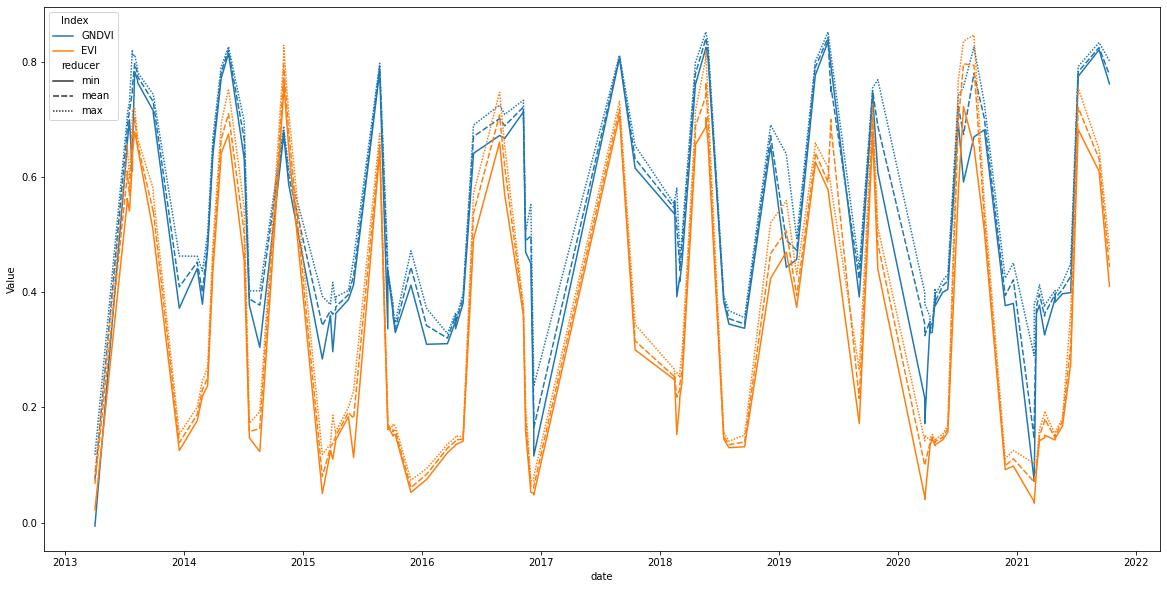

In [13]:
plt.figure(figsize = (20,10))
sns.lineplot(data = tsPandas,
             x = 'date',
             y = 'Value',
             hue = 'Index',
             style = 'reducer')